In [150]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch.unitroot import ADF
from statsmodels.tsa.api import VAR
import yfinance as yf
import datetime

In [151]:
end = datetime.datetime.today()
timedelta = datetime.timedelta(days=2 * 365)  # Get 2 years of data
start = end - timedelta
df = yf.download(["BTC-USD", "ETH-USD"], start, end)["Adj Close"]

[*********************100%%**********************]  2 of 2 completed


In [152]:
# Calculate percent changes
df["pct_change_BTC"] = df["BTC-USD"].pct_change()
df["pct_change_ETH"] = df["ETH-USD"].pct_change()
df = df.dropna()
df.head(5)

,BTC-USD,ETH-USD,pct_change_BTC,pct_change_ETH
Date,,,,
2021-12-24,50822.195312,4047.982910,0.000741,-0.014614
2021-12-25,50429.859375,4093.281006,-0.007720,0.011190
2021-12-26,50809.515625,4067.328125,0.007528,-0.006340
2021-12-27,50640.417969,4037.547607,-0.003328,-0.007322
2021-12-28,47588.855469,3800.893066,-0.060259,-0.058613


<Axes: xlabel='Date'>

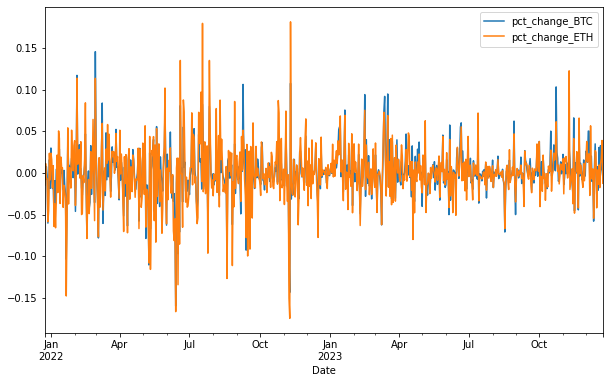

In [153]:
df.loc[:, ["pct_change_BTC", "pct_change_ETH"]].plot(figsize=(10, 6))

In [154]:
# Conduct Augmented Dickey-Fuller tests on pct_change_BTC and pct_change_ETH
ADF_pct_change_BTC = ADF(df["pct_change_BTC"], trend="n", method="bic")
ADF_pct_change_ETH = ADF(df["pct_change_ETH"], trend="n", method="bic")
adf_df = pd.DataFrame({"ADF p-value":[ADF_pct_change_BTC.pvalue, ADF_pct_change_ETH.pvalue]})
adf_df.index = ["pct_change_BTC", "pct_change_ETH"]
adf_df

,ADF p-value
pct_change_BTC,0.0
pct_change_ETH,0.0


As can be seen, because ADF $p$ value is $p < 0.05$, we can decide both percent differences time series are stationary.

In [155]:
pct_data = df.iloc[:, -2:]
pct_data

,pct_change_BTC,pct_change_ETH
Date,,
2021-12-24,0.000741,-0.014614
2021-12-25,-0.007720,0.011190
2021-12-26,0.007528,-0.006340
2021-12-27,-0.003328,-0.007322
2021-12-28,-0.060259,-0.058613
...,...,...
2023-12-19,-0.008282,-0.017770
2023-12-20,0.032688,0.011038
2023-12-21,0.004969,0.017090


In [156]:
# Fit VAR model and select the best lag
model = VAR(pct_data)
model.select_order(maxlags=12, trend="c").summary()  # show the different AIC and BIC values for different lags and we'll pick the minimum.


/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-15.15*,-15.13*,2.641e-07*,-15.14*
1,-15.14,-15.10,2.662e-07,-15.12
2,-15.13,-15.07,2.680e-07,-15.11
3,-15.13,-15.04,2.691e-07,-15.09
4,-15.12,-15.00,2.717e-07,-15.07
5,-15.11,-14.97,2.743e-07,-15.05
6,-15.11,-14.95,2.737e-07,-15.05
7,-15.11,-14.91,2.751e-07,-15.03
8,-15.11,-14.89,2.744e-07,-15.02
9,-15.11,-14.87,2.743e-07,-15.02


According to the order selection, with an optimum lag of 0, a VAR($p$) model does not seem to improve forecasting power and we don't need a VAR(p) fit.

In [157]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch.unitroot import ADF
from statsmodels.tsa.api import VAR
import yfinance as yf
import datetime

# Download last 2 years of data for google, microsoft, amazon and nvidia
end = datetime.datetime.today()
timedelta = datetime.timedelta(days=2 * 365)  # Get 2 years of data
start = end - timedelta
df = yf.download(["GOOG", "MSFT", "AMZN", "NVDA"], start, end)["Adj Close"]

[*********************100%%**********************]  4 of 4 completed


In [158]:
df.head()

,AMZN,GOOG,MSFT,NVDA
Date,,,,
2021-12-23,171.068497,147.142502,328.668732,295.991760
2021-12-27,169.669495,148.063995,336.289124,309.023804
2021-12-28,170.660995,146.447998,335.110748,302.802338
2021-12-29,169.201004,146.504501,335.798187,299.596771
2021-12-30,168.644501,146.002502,333.215424,295.452484


<Axes: xlabel='Date'>

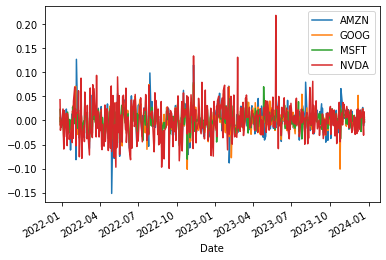

In [159]:
# Create pct_change dataframe
cols = tuple(df.columns)
log_dict = {}
for col in cols:
    log_dict[col] = np.log((df[col] / df[col].shift(1)))
log_df = pd.DataFrame(log_dict, index=df.index).dropna()
log_df.plot()

In [160]:
log_df_VAR = VAR(log_df)
log_df_VAR.select_order(maxlags=12, trend="n").summary()

/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-31.71,-31.58,1.689e-14,-31.66
1,-31.70*,-31.43*,1.709e-14*,-31.59*
2,-31.67,-31.26,1.756e-14,-31.51
3,-31.64,-31.09,1.820e-14,-31.42
4,-31.60,-30.92,1.887e-14,-31.33
5,-31.56,-30.74,1.973e-14,-31.23
6,-31.55,-30.59,1.986e-14,-31.17
7,-31.52,-30.43,2.046e-14,-31.09
8,-31.48,-30.25,2.136e-14,-30.99
9,-31.43,-30.06,2.240e-14,-30.89


Then we select $p=1$ for our VAR($p$) model.

In [161]:
results = VAR(log_df).fit(
    maxlags=None,
    # when maxlags=None criterion to use for VAR order selection is
    # ic{'aic', 'fpe', 'hqic', 'bic', None}
    ic=None,  # ic=None => automatic lag selection
    method="ols",
    trend="n",
    verbose=True,
)
results.summary()

/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 23, Dec, 2023
Time:                     16:13:01
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -31.6269
Nobs:                     501.000    HQIC:                  -31.7088
Log likelihood:           5128.73    FPE:                1.60736e-14
AIC:                     -31.7616    Det(Omega_mle):     1.55703e-14
--------------------------------------------------------------------
Results for equation AMZN
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
L1.AMZN         0.016437         0.067124            0.245           0.807
L1.GOOG        -0.202963         0.086670           -2.342           0.019
L1.MSFT         0.162096         0.105550            1.536           0.125
L1.NVDA   

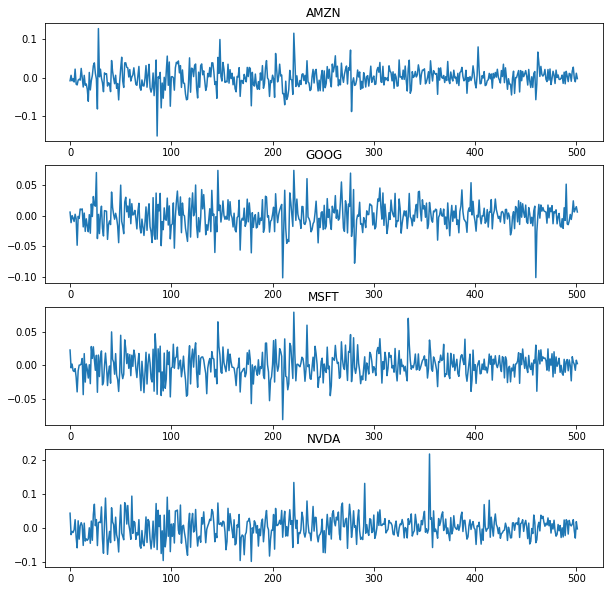

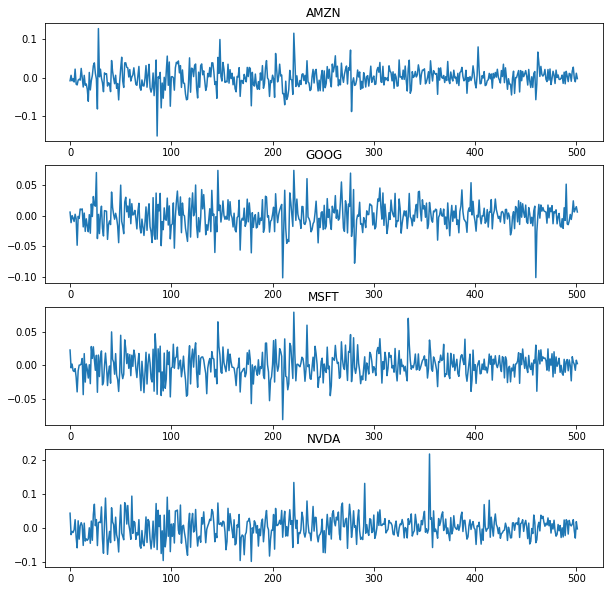

In [162]:
results.plot()

In [163]:
coefs = results.coefs[0]
# const = results.intercept
print(coefs)
# print(const)

[[ 0.01643729 -0.20296294  0.16209588  0.00310018]
 [ 0.02021713 -0.04482414  0.0463967  -0.00090398]
 [-0.00632382 -0.06720216  0.04085128  0.00976362]
 [ 0.11798594 -0.26311314  0.14947852  0.00314836]]


In [164]:
# Store coefficients in a dataframe, all lag 1
coef_df_var1 = pd.DataFrame(coefs, columns=["AMZN coef", "GOOG coef", "MSFT coef", "NVDA coef"],
                            index=["AMZN equation", "GOOG equation", "MSFT equation", "NVDA equation"])
coef_df_var1

,AMZN coef,GOOG coef,MSFT coef,NVDA coef
AMZN equation,0.016437,-0.202963,0.162096,0.003100
GOOG equation,0.020217,-0.044824,0.046397,-0.000904
MSFT equation,-0.006324,-0.067202,0.040851,0.009764
NVDA equation,0.117986,-0.263113,0.149479,0.003148


Now let's use our VAR(1) model to forecast GOOG percent returns:

<Axes: xlabel='Date'>

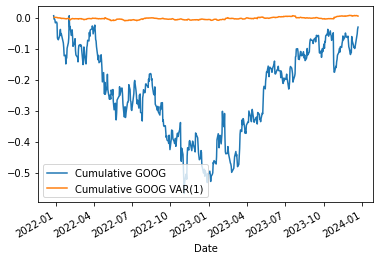

In [166]:
log_df["GOOG VAR(1)"] = log_df["AMZN"].shift(1) * coef_df_var1.iloc[1, 0] + log_df["GOOG"].shift(1) * coef_df_var1.iloc[1, 1] + log_df["MSFT"].shift(1) * coef_df_var1.iloc[1, 2] + log_df["NVDA"].shift(1) * coef_df_var1.iloc[1, 3]
log_df["Cumulative GOOG"] = log_df["GOOG"].cumsum()
log_df["Cumulative GOOG VAR(1)"] = log_df["GOOG VAR(1)"].cumsum()
log_df.iloc[:, -2:].plot()

> As we can see, this is a shit fit that has no use whatsoever.